In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'vbiv' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-14,3.4600,3.1150,3.1800,3.340,9217199.0,3.340,-0.050314,0.110754,0.067093,0.041320,0.003085,-1
2020-12-15,3.3683,3.1700,3.3600,3.250,4085328.0,3.250,0.032738,0.062555,-0.026946,0.043357,-0.000486,1
2020-12-16,3.2850,3.1600,3.2600,3.190,3048929.0,3.190,0.021472,0.039557,-0.018462,0.037524,0.004996,1
2020-12-17,3.3800,3.1209,3.2400,3.350,5801022.0,3.350,-0.033951,0.083021,0.050157,0.042807,0.012784,-1
2020-12-18,3.4200,3.2300,3.4000,3.235,10865689.0,3.235,0.048529,0.058824,-0.034328,0.047384,0.007503,1
2020-12-21,3.5300,3.1400,3.2000,3.480,9817215.0,3.480,-0.087500,0.124204,0.075734,0.050176,0.009231,-1
2020-12-22,3.6300,3.3300,3.5000,3.500,8316824.0,3.500,0.000000,0.090090,0.005747,0.046261,0.015770,-1
2020-12-23,3.5000,3.2701,3.4900,3.330,6691541.0,3.330,0.045845,0.070304,-0.048571,0.053261,0.009748,-1
2020-12-24,3.3599,3.1200,3.3135,3.120,3790964.0,3.120,0.058397,0.076891,-0.063063,0.055794,-0.012896,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# va.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

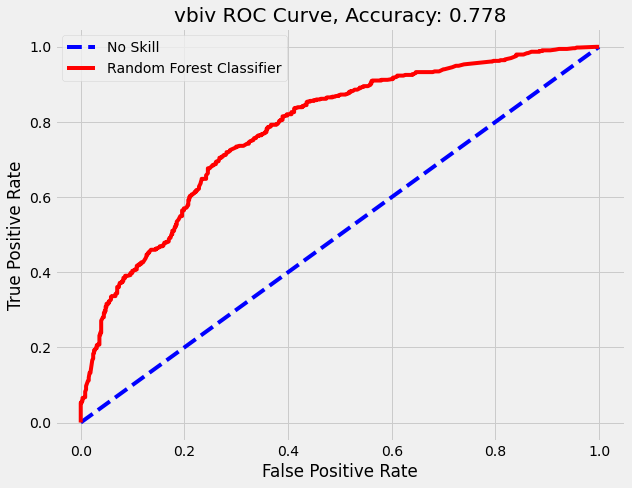

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

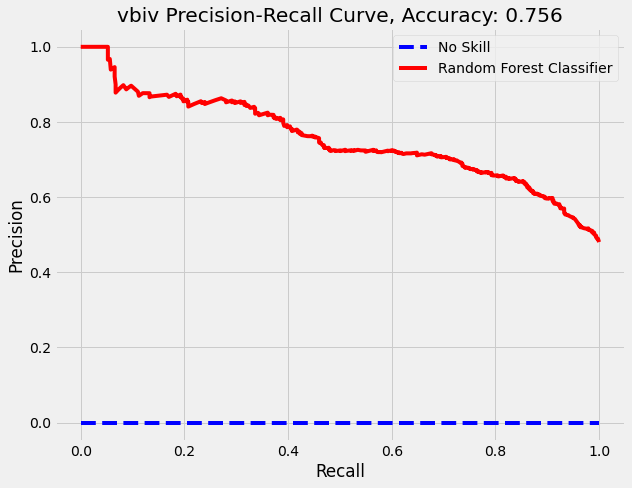

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

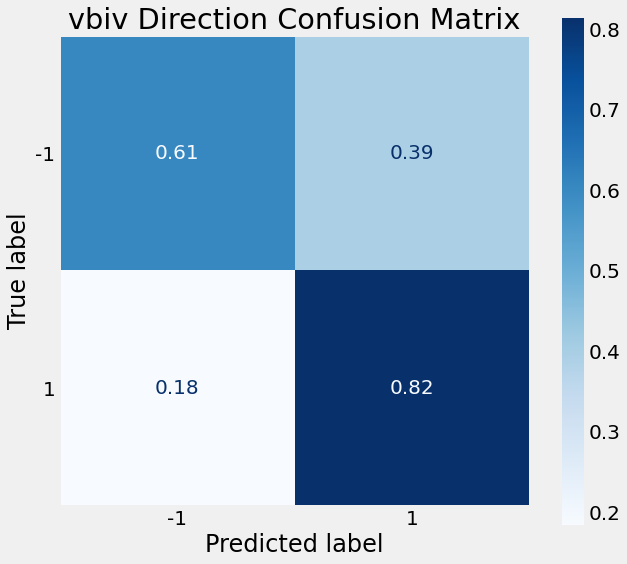

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6639199741464185'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          3.120000e+00
Low           2.930000e+00
Open          3.097100e+00
Close         3.035000e+00
Volume        3.843477e+06
Adj Close     3.035000e+00
oc            2.005099e-02
hl            6.484635e-02
adj          -2.724353e-02
5stdev_adj    5.520002e-02
5sma_adj     -1.147935e-02
direction    -1.000000e+00
Name: 2020-12-28 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.020051
hl            0.064846
5stdev_adj    0.055200
5sma_adj     -0.011479
Name: 2020-12-28 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy vbiv


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-21,3.5300,3.1400,3.2000,3.480,9817215.0,3.480,-0.087500,0.124204,0.075734,0.050176,0.009231,-1,-1,-0.005747
2020-12-22,3.6300,3.3300,3.5000,3.500,8316824.0,3.500,0.000000,0.090090,0.005747,0.046261,0.015770,-1,1,-0.048571
2020-12-23,3.5000,3.2701,3.4900,3.330,6691541.0,3.330,0.045845,0.070304,-0.048571,0.053261,0.009748,-1,1,-0.063063
2020-12-24,3.3599,3.1200,3.3135,3.120,3790964.0,3.120,0.058397,0.076891,-0.063063,0.055794,-0.012896,1,1,-0.027244
2020-12-28,3.1200,2.9300,3.0971,3.035,3843477.0,3.035,0.020051,0.064846,-0.027244,0.055200,-0.011479,-1,1,0.000000


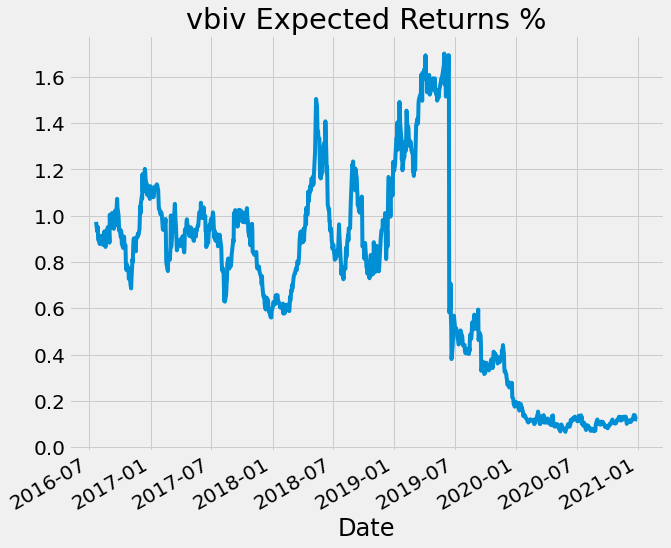

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

0.5996190805317897

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

-0.8798019767987846

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/